In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
# import libpython
# get_ipython().run_line_magic('matplotlib', 'inline')
from fastai.tabular.core import add_datepart
import holidays
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error
sns.color_palette("husl")
sns.set_style('darkgrid')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
media = pd.read_csv('./data/mediamix_sales.csv', sep=',')
holiday = holidays.USA()
media['Time'] = pd.to_datetime(media['Time'])
media['Time'] = media['Time'].dt.strftime('%Y-%d-%m')
media['holiday'] = media['Time'].apply(lambda x: x in holiday)
media = add_datepart(media,'Time',)
media.drop(['TimeElapsed','TimeDay','TimeIs_month_end','TimeIs_year_end','TimeIs_quarter_end'],axis=1,inplace=True)
lb = LabelEncoder()
media[['holiday', 'TimeIs_quarter_start','TimeIs_year_start']] = media[['holiday', 'TimeIs_quarter_start','TimeIs_year_start']].apply(lb.fit_transform)
media.head()

,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,...,sales,holiday,TimeYear,TimeMonth,TimeWeek,TimeDayofweek,TimeDayofyear,TimeIs_month_start,TimeIs_quarter_start,TimeIs_year_start
0,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,...,22100,1,2001,1,1,0,1,True,1,1
1,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,...,10400,0,2001,2,5,3,32,True,0,0
2,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,...,9300,0,2001,3,9,3,60,True,0,0
3,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,...,18500,0,2001,4,13,6,91,True,1,0
4,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,...,12900,0,2001,5,18,1,121,True,0,0


In [6]:
#cntl
cntl_cols = ['holiday', 'TimeIs_quarter_start',
       'TimeIs_year_start']
#media
media_cols = ['tv_sponsorships', 'tv_cricket', 'tv_RON', 'radio', 'NPP', 'Magazines',
       'OOH', 'Social', 'Programmatic', 'Display_Rest', 'Search', 'Native']
#sales
sales = ['sales']

In [58]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        # md = md_col.split('_')[-1]
        md = md_col
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope)) 

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm,mu

def mean_center_trandform(df,cols):
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
       df_new[col]=apply_mean_center(df[col])[0]
       sc[col]=apply_mean_center(df[col])[1]
    return df_new,sc

def mean_log1p_trandform(df, cols):
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
       df_new[col]=apply_mean_center(df[col])[0]
       df_new[col] = np.log(df_new[col])
       sc[col]=apply_mean_center(media[col])[1]
    return df_new,sc

def save_json(df,file_name):
    with open(file_name,mode='w') as f:
        json.dump(obj=df,fp=f)  

def load_json(file_name):
    with open(file_name,mode='r') as f:
        d = json.load(fp=f)
    return d

In [8]:
df_ctrl,sc_ctrl = mean_center_trandform(media,cols=cntl_cols + ['sales'])
df_ctrl = df_ctrl[cntl_cols]
X1 = df_ctrl.values

ctrl_data = {
    'N':len(media),
    'K1':len(cntl_cols),
    'X1': X1,
    'y': media['sales'].values,
    'max_intercept': min(media['sales'])
}

ctrl_code = '''
data {
int N;
int K1;
real max_intercept;
matrix[N, K1] X1;
vector[N] y;
}

parameters {
    vector[K1] beta;
    real<lower=0,upper=max_intercept> alpha;
    real<lower=0> noise;
}

model {
   beta ~ normal(0, 1);
   noise ~ inv_gamma(0.05, 0.05 * 0.01); 

   y ~ normal(X1*beta + alpha, sqrt(noise));
}
'''

sm1 = pystan.StanModel(model_code=ctrl_code,verbose=True)
fit1 = sm1.sampling(iter=1000,chains=4,data=ctrl_data)
extract_result = fit1.extract()
extract_result

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0857d44dd7a574256b700f4192840a69 NOW.
INFO:pystan:OS: win32, Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)], Cython 0.29.28


Compiling C:\Users\sourish.dey\AppData\Local\Temp\pystan_jafizhr1\stanfit4anon_model_0857d44dd7a574256b700f4192840a69_8533415284517494991.pyx because it changed.
[1/1] Cythonizing C:\Users\sourish.dey\AppData\Local\Temp\pystan_jafizhr1\stanfit4anon_model_0857d44dd7a574256b700f4192840a69_8533415284517494991.pyx
building 'stanfit4anon_model_0857d44dd7a574256b700f4192840a69_8533415284517494991' extension
C:\ProgramData\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\sourish.dey\AppData\Local\Temp\pystan_jafizhr1 -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\src -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.69.0 -Ic:\ProgramData\Anaconda3\

OrderedDict([('beta',
              array([[-1.41637181,  0.5299118 , -0.70145868],
                     [-0.67540973,  0.60916982,  1.89206571],
                     [-0.17210627,  0.53110548, -0.63148532],
                     ...,
                     [-0.58586422, -0.49883912, -0.68023075],
                     [-0.0212719 ,  1.01804748,  0.43358055],
                     [-1.36825132,  0.23643855, -0.83456082]])),
             ('alpha',
              array([1582.5101586 , 1540.96449668, 1513.6293868 , ..., 1599.74278456,
                     1564.06423231, 1555.62834855])),
             ('noise',
              array([1.65951333e+08, 1.86056475e+08, 2.00071939e+08, ...,
                     2.04975863e+08, 1.94808941e+08, 1.69178918e+08])),
             ('lp__',
              array([-2001.80022409, -2001.53787028, -2000.07460631, ...,
                     -2005.20620881, -2000.32060875, -2001.04690422]))])

In [9]:
def get_ctrl_model(extract_result,extract_list = False):
    ctrl_model = {}
    ctrl_model['beta'] = extract_result['beta'].mean(axis=0).tolist()
    ctrl_model['alpha'] = extract_result['alpha'].mean()
    if extract_list: 
        ctrl_model['beta'] = extract_result['beta'].mean(axis=0).tolist()
        ctrl_model['alpha'] = extract_result['alpha'].tolist()
    return ctrl_model

def get_ctrl_prediction(ctrl_model,ctrl_data):
    beta = ctrl_model['beta']
    X1 = ctrl_data.values
    y_pred = np.dot(X1,beta) + ctrl_model['alpha']
    return y_pred
ctrl_model = get_ctrl_model(extract_result,extract_list = False)
y_pred_base = get_ctrl_prediction(ctrl_model,df_ctrl)
# y_pred_base = y_pred_base * sc_ctrl['sales']
mean_absolute_percentage_error(media['sales'],y_pred_base)


0.8698299688750079

### Adstock mmm model

In [10]:
media['base_sales'] = y_pred_base
df_mmm,sc_mmm = mean_log1p_trandform(media,['sales','base_sales'])
num_media = len(media_cols)
max_lag = 8
mu_med = np.mean(media[media_cols],axis=0).values
X_ctrl = media['base_sales'].values.reshape(len(media),1)
X_media = np.concatenate((np.zeros((max_lag-1,num_media)),media[media_cols].values),axis=0)

#data
mmm_data = {
    'N':len(media),
    'num_media':num_media,
    'X_ctrl':X_ctrl,
    'max_lag':max_lag,
    'X_media':X_media,
    'mu':mu_med,
    'num_ctrl':X_ctrl.shape[1],
    # 'y_ctrl': df_mmm['sales'].values,
    'y':df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=mmm_data, iter=100, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d063204c96d8afa4351deb7f00c8312 NOW.
INFO:pystan:OS: win32, Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)], Cython 0.29.28


Compiling C:\Users\sourish.dey\AppData\Local\Temp\pystan_c8wqumxl\stanfit4anon_model_3d063204c96d8afa4351deb7f00c8312_4990668802939164175.pyx because it changed.
[1/1] Cythonizing C:\Users\sourish.dey\AppData\Local\Temp\pystan_c8wqumxl\stanfit4anon_model_3d063204c96d8afa4351deb7f00c8312_4990668802939164175.pyx
building 'stanfit4anon_model_3d063204c96d8afa4351deb7f00c8312_4990668802939164175' extension
C:\ProgramData\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\sourish.dey\AppData\Local\Temp\pystan_c8wqumxl -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\src -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -Ic:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.69.0 -Ic:\ProgramData\Anaconda3\

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [46]:
mmm

{'max_lag': 8,
 'media_vars': ['tv_sponsorships',
  'tv_cricket',
  'tv_RON',
  'radio',
  'NPP',
  'Magazines',
  'OOH',
  'Social',
  'Programmatic',
  'Display_Rest',
  'Search',
  'Native'],
 'ctrl_var': ['base_sales'],
 'decay': [0.05264893051501527,
  0.19292394916126882,
  0.07772557345647675,
  0.10122353411920784,
  0.4891936084873803,
  0.4464777545607905,
  0.5292011986289801,
  0.4411373850370167,
  0.5090620402232745,
  0.5019397396380578,
  0.4985289495437422,
  0.46506789779934804],
 'beta': [0.5292841394352913,
  0.35760245356271303,
  0.40170265817707085,
  0.5962928350358717,
  0.045839968042460676,
  0.03720102745891192,
  0.03920704145861083,
  0.05578268156141865,
  0.16395952888388596,
  0.013444702350168003,
  0.014323305619673411,
  0.12428793152863941,
  0.0009073792492987424],
 'peak': [0.1854854035533184,
  0.08065680457205464,
  0.049586858235907284,
  0.0648322213062747,
  1.7906893916385067,
  1.945840526200015,
  1.6237345256955082,
  1.4788362065547245,


tv_sponsorships
tv_cricket
tv_RON
radio
NPP
Magazines
OOH
Social
Programmatic
Display_Rest
Search
Native


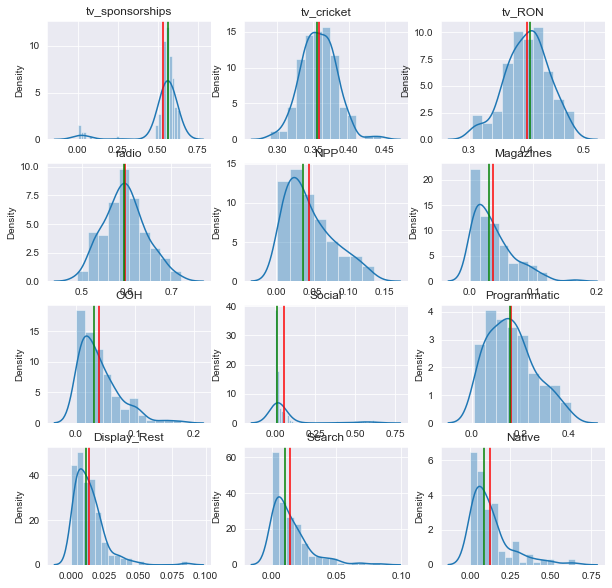

In [45]:
def extract_mmm(fit2_result,max_lag=max_lag,media_vars=media_cols,ctrl_var = ['base_sales'],extract_param_list = True):
    mmm={}

    mmm['max_lag'] = max_lag
    mmm['media_vars'],mmm['ctrl_var'] = media_cols,ctrl_var
    mmm['decay'] = decay = np.mean(fit2_result['decay'],axis=0).tolist()
    mmm['beta'] = beta = np.mean(fit2_result['beta'],axis=0).tolist()
    mmm['peak'] = peak = np.mean(fit2_result['peak'],axis=0).tolist()
    mmm['tau'] = np.mean(fit2_result['tau'])
    if extract_param_list:
        mmm['beta_list'] = fit2_result['beta'].tolist()
        mmm['decay_list'] = fit2_result['decay'].tolist()
        mmm['peak_list'] = fit2_result['peak'].tolist()
        mmm['tau_list'] = fit2_result['tau'].tolist()
    adstock = {}
    for i in range(len(media_vars)):
        adstock[media_vars[i]] = {'P':peak[i],
        'L':max_lag,'D':decay[i]}
    mmm['adstock_params'] = adstock
    return mmm   

mmm = extract_mmm(fit2_result,max_lag=max_lag,media_vars=media_cols,ctrl_var = ['base_sales'],extract_param_list = True) 

beta_media = {}
for i in range(len(media_cols)):
    md = media_cols[i]
    print(md)
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = betas        

f = plt.figure(figsize=(10,10))
for i in range(len(media_cols)):
    ax = f.add_subplot(4,3,i+1)
    md = beta_media[media_cols[i]]
    mean = np.mean(md)
    median = np.median(md)
    ax = sns.distplot(md)
    ax.axvline(mean, color='r', linestyle='-')
    ax.axvline(median, color='g', linestyle='-')
    ax.set_title(media_cols[i])

In [114]:
##Decompose sales

def mmm_decompose_contrib(mmm,media,num_media):
#Coefficient and intercepts
    betas,tau = mmm['beta'],mmm['tau']
#Media and control vars
    ctrl_vars = mmm['ctrl_var']
    num_ctrl = len(ctrl_vars)
#X data set
# media - adstock_transform and mean center
    X_media = adstock_transform(media,media_cols,adstock_params=mmm['adstock_params'])
    X_media,sc_mmm = mean_center_trandform(X_media,mmm['media_vars'])
    X_media += 1
# ctrl - mean center transform 
    X_ctrl,sc_mmm1 = mean_center_trandform(media,ctrl_vars) 
    X_ctrl += 1
    # X_ctrl = media['base_sales']
# dependent - sales
    y_true,sc_mmm2 = mean_center_trandform(media,['sales'])        
    y_true += 1
    sc_mmm.update(sc_mmm1)
    sc_mmm.update(sc_mmm2)
# X data
    X1 = pd.concat([X_media,X_ctrl],axis=1)
#Multiplicative model prediction
    factor_df = pd.DataFrame(columns = media_cols + ctrl_vars)
    for i,md in enumerate(media_cols + ctrl_vars):
        factor_df[md] = X1[md] ** betas[i]
    # factor_df['intercept'] = np.expm1(tau)      

# Calculate prediction and actual
    y_pred = factor_df.apply(np.prod,axis=1) 
    factor_df['y_pred'] = y_pred
    factor_df['y_true'] = y_true
    y_pred_base = factor_df[ctrl_vars].apply(np.prod,axis=1) 
    factor_df['y_pred_base'] = y_pred_base
#media contrib %%
    mc_df = pd.DataFrame(columns = media_cols + ['baseline'])
    for col in media_cols:
        mc_df[col] = factor_df['y_true'] - factor_df['y_true']/factor_df[col]
    mc_df['y_true'] = y_true
    mc_df['baseline'] = factor_df['y_pred_base']
#media contribution and marginal contribution
    mc_df['mc_media_pred'] = mc_df[media_cols].apply(np.sum,axis=1)    
    mc_df['media_act'] = mc_df['y_true'] - mc_df['baseline']
    mc_df['media_delta'] = abs(mc_df['mc_media_pred']-mc_df['media_act'])
    for col in media_cols:
        mc_df[col] = mc_df[col] - mc_df['media_delta'] * mc_df[col]/mc_df['mc_media_pred'] 
    print(f'MAPE:{mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(np.log1p(y_true),np.log1p(y_pred))}')
    return mc_df, factor_df


mc_df, factor_df = mmm_decompose_contrib(mmm,media,num_media)

MAPE:1.3053802213865082
MAPE: 0.5546367276362192


In [77]:
betas,tau = mmm['beta'],mmm['tau']
#Media and control vars
ctrl_vars = mmm['ctrl_var']
num_ctrl = len(ctrl_vars)
#X data set
# media - adstock_transform and mean center
X_media = adstock_transform(media,media_cols,adstock_params=mmm['adstock_params'])
X_media,sc_mmm = mean_center_trandform(X_media,mmm['media_vars'])
X_media += 1
# ctrl - mean center transform 
X_ctrl,sc_mmm1 = mean_center_trandform(media,ctrl_vars) 
X_ctrl += 1
# dependent - sales
y_true,sc_mmm2 = mean_center_trandform(media,['sales'])        
y_true += 1
sc_mmm.update(sc_mmm1)
sc_mmm.update(sc_mmm2)
# X data
X1 = pd.concat([X_media,X_ctrl],axis=1)
X1


,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,base_sales
0,2.738865,2.279292,1.777790,2.430102,1.110045,1.073051,1.101249,1.164552,1.015054,1.116524,1.065663,1.044157,1.999996
1,1.609173,1.569242,1.228305,2.681669,1.768567,1.799737,1.524447,1.848617,1.101733,1.641436,1.474660,1.364094,1.999993
2,1.182874,1.160882,1.073250,2.939372,2.620370,3.107026,2.019828,1.959247,1.231062,1.956590,1.901985,1.909226,1.999993
3,2.165307,1.866939,1.517935,2.799365,2.862083,3.452615,2.182224,1.470293,1.281068,1.562366,1.584982,2.204851,2.000026
4,2.545985,2.217323,1.662429,1.621787,3.022328,3.706522,2.197134,1.760165,1.286079,1.638671,1.521924,2.235277,1.999993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.224183,1.365472,1.473236,1.323765,1.411812,1.220577,1.513223,1.549770,2.144840,1.505332,1.449917,1.996904,2.000026
196,1.364062,1.499238,1.872048,1.204709,1.411812,1.220577,1.513223,1.396248,2.144840,1.429617,1.426293,1.996904,1.999993
197,1.696791,1.962351,2.658403,1.377131,1.411812,1.220577,1.513223,1.332871,2.144840,1.326625,1.302714,1.996904,1.999993
198,2.131311,2.573739,3.680429,2.636968,1.411812,1.220577,1.513223,1.568410,2.144840,1.490815,1.408959,1.996904,2.000026


In [81]:
betas

[0.5292841394352913,
 0.35760245356271303,
 0.40170265817707085,
 0.5962928350358717,
 0.045839968042460676,
 0.03720102745891192,
 0.03920704145861083,
 0.05578268156141865,
 0.16395952888388596,
 0.013444702350168003,
 0.014323305619673411,
 0.12428793152863941,
 0.0009073792492987424]